# Stock Market Prediction Model of the Magnificient Seven 

#pip install the dependencies from requirements. May take up to 12 minutes

In [112]:
!python3 -m pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


### importing our libraries after pipinstall

In [113]:

#python data manipulation
import pandas as pd
import numpy as np

#data visualizaiton tools, EDA
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

#mysql and Cassandra
from cassandra.cluster import Cluster          

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
#ARIMA
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm



#LSTM Neural network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf

# our finance data
import yfinance as yf



## Extracting the Historical Data.


 ### The historical aspect of the data is starting from January 1st 2020 to yesterday (april 6th), We can adjust this to most recent always. We extracted the 7 companies and start with first 7 features from our project proposal: Date/time, open price, low price, high price, adjusted close price, trading volume

In [114]:
def extract_data(tickers, start_date="2020-01-01", end_date="2025-04-06", interval="1d"):
    # importing the yfinance api data, making sure the autoadjust is off because it overrides the close value if its on
    df = yf.download(tickers, start=start_date, end=end_date, interval=interval, auto_adjust=False)
    # tidying the data to make it better for analysis and transformation later
    df.columns = df.columns.swaplevel(0, 1)
    df = df.sort_index(axis=1, level=0)
    df_flat = df.stack(level=0, future_stack=True).reset_index()  
    df_flat.rename(columns={'level_0': 'Date'}, inplace=True)
    # renaming 'Adj Close' to 'Adj_Close' for consistency
    if 'Adj Close' in df_flat.columns:
        df_flat.rename(columns={'Adj Close': 'Adj_Close'}, inplace=True)
    # adding the previous day's close price per ticker
    df_flat['Previous_Close'] = df_flat.groupby('Ticker')['Close'].shift(1)
    # selecting the columns we expect and need
    expected_cols = ['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Adj_Close', 'Previous_Close', 'Volume']
    existing_cols = [col for col in expected_cols if col in df_flat.columns]
    return df_flat[existing_cols]


In [115]:
#giving yfinance a list of companies to return a list of data of. AND displaying the df
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "NVDA", "TSLA"]
df_raw = extract_data(tickers)
display(df_raw)

[*********************100%***********************]  7 of 7 completed


Price,Date,Ticker,Open,High,Low,Close,Adj_Close,Previous_Close,Volume
0,2020-01-02,AAPL,74.059998,75.150002,73.797501,75.087502,72.716080,NaN,135480400
1,2020-01-02,AMZN,93.750000,94.900497,93.207497,94.900497,94.900497,NaN,80580000
2,2020-01-02,GOOGL,67.420502,68.433998,67.324501,68.433998,68.108383,NaN,27278000
3,2020-01-02,META,206.750000,209.789993,206.270004,209.779999,208.795929,NaN,12077100
4,2020-01-02,MSFT,158.779999,160.729996,158.330002,160.619995,153.323257,NaN,22622100
...,...,...,...,...,...,...,...,...,...
9249,2025-04-04,GOOGL,148.009995,151.070007,145.380005,145.600006,145.600006,150.720001,62259500
9250,2025-04-04,META,506.619995,518.000000,494.200012,504.730011,504.730011,531.619995,38589800
9251,2025-04-04,MSFT,364.130005,374.589996,359.480011,359.839996,359.839996,373.109985,49209900
9252,2025-04-04,NVDA,98.910004,100.129997,92.110001,94.309998,94.309998,101.800003,532273800


## Historical Data: Data Cleaning: 
### We will clean the data by taking care of any null values. We can use back and forward filling if there is a value missing from a float/int value. Otherwise we will drop the value if its in the date or Ticker/ or use the average of the past few days for the column. Additionally if there are are any duplicate records for a company and a speciifc date, one should be kept while rest dropped.

In [116]:
nans = df_raw.isna().sum()
print(nans)
def cleaning(df):
    # Step 1: Drop duplicates (keep the first entry for each Ticker-Date pair)
    df = df.drop_duplicates(subset=['Date', 'Ticker'], keep='first')

    # Step 2: Define numeric columns to clean (excluding 'Date' and 'Ticker')
    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume', 'Previous_Close']
    
    # Step 3: Fill missing values for numeric columns
    for col in numeric_cols:
        # Forward fill and backward fill first
        df[col] = df.groupby('Ticker')[col].transform(lambda x: x.ffill().bfill())
        
        # Fill remaining NaNs with rolling mean (3-day window)
        df[col] = df.groupby('Ticker')[col].transform(
            lambda x: x.fillna(x.rolling(window=3, min_periods=1).mean())
        )

    # Step 4: Ensure 'Previous_Close' is properly filled (first entry has no previous data)
    df['Previous_Close'] = df.groupby('Ticker')['Previous_Close'].ffill()

    # Step 5: Drop rows with nulls in 'Date' or 'Ticker' (shouldn't exist, but safety check)
    df = df.dropna(subset=['Date', 'Ticker'])

    return df
# Apply cleaning
df_cleaned = cleaning(df_raw)

# Verify results
print("Null values after cleaning:")
print(df_cleaned.isna().sum())
display(df_cleaned)

Price
Date              0
Ticker            0
Open              0
High              0
Low               0
Close             0
Adj_Close         0
Previous_Close    7
Volume            0
dtype: int64
Null values after cleaning:
Price
Date              0
Ticker            0
Open              0
High              0
Low               0
Close             0
Adj_Close         0
Previous_Close    0
Volume            0
dtype: int64


Price,Date,Ticker,Open,High,Low,Close,Adj_Close,Previous_Close,Volume
0,2020-01-02,AAPL,74.059998,75.150002,73.797501,75.087502,72.716080,75.087502,135480400
1,2020-01-02,AMZN,93.750000,94.900497,93.207497,94.900497,94.900497,94.900497,80580000
2,2020-01-02,GOOGL,67.420502,68.433998,67.324501,68.433998,68.108383,68.433998,27278000
3,2020-01-02,META,206.750000,209.789993,206.270004,209.779999,208.795929,209.779999,12077100
4,2020-01-02,MSFT,158.779999,160.729996,158.330002,160.619995,153.323257,160.619995,22622100
...,...,...,...,...,...,...,...,...,...
9249,2025-04-04,GOOGL,148.009995,151.070007,145.380005,145.600006,145.600006,150.720001,62259500
9250,2025-04-04,META,506.619995,518.000000,494.200012,504.730011,504.730011,531.619995,38589800
9251,2025-04-04,MSFT,364.130005,374.589996,359.480011,359.839996,359.839996,373.109985,49209900
9252,2025-04-04,NVDA,98.910004,100.129997,92.110001,94.309998,94.309998,101.800003,532273800


## Historical Data, Feature Engineering:

### We are going to be transforming the tidy dataframe by doing some feature engineering. We will create the following fields into our table by manipulating the prexisting data from df_cleaned: 
1. Simple Moving Average (SMA)
2. Exponential Moving Average (EMA)
3. Relative Strength Index (RSI)
4. Bollinger Bands
5. MACD (Moving Average Convergence Divergence)
6. On-Balance Volume (OBV)
7. Volatility (ATR - Average True Range)


In [117]:
def transform(df):
    # Ensure data is sorted by Ticker and Date
    df = df.sort_values(['Ticker', 'Date']).reset_index(drop=True)
    
    # 1. Simple Moving Average (SMA)
    #uses 20 periods of data (NaN till 19 row)
    df['SMA_20'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=20).mean())
    
    # 2. Exponential Moving Average (EMA)
    df['EMA_20'] = df.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span=20, adjust=False).mean())
    
    # 3. Relative Strength Index (RSI)
    #uses 14 periods of data (NaN till 13 row)
    def compute_rsi(data, period=14):
        delta = data.diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(window=period).mean()
        avg_loss = loss.rolling(window=period).mean()
        rs = avg_gain / avg_loss
        return 100 - (100 / (1 + rs))
    df['RSI_14'] = df.groupby('Ticker')['Close'].transform(compute_rsi)
    
    # 4. Bollinger Bands
    #NaN till we get SMA values (19th row)
    df['BB_Middle'] = df['SMA_20']
    df['BB_Std'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=20).std())
    df['BB_Upper'] = df['BB_Middle'] + 2 * df['BB_Std']
    df['BB_Lower'] = df['BB_Middle'] - 2 * df['BB_Std']
    
    # 5. MACD
    def compute_macd(data):
        ema12 = data.ewm(span=12, adjust=False).mean()
        ema26 = data.ewm(span=26, adjust=False).mean()
        return ema12 - ema26
    df['MACD'] = df.groupby('Ticker')['Close'].transform(compute_macd)
    df['MACD_Signal'] = df.groupby('Ticker')['MACD'].transform(lambda x: x.ewm(span=9, adjust=False).mean())
    
    # # 6. On-Balance Volume (OBV)
    # def compute_obv(group):
    #     obv = (np.where(group['Close'].diff() > 0, group['Volume'],
    #             np.where(group['Close'].diff() < 0, -group['Volume'], 0))).cumsum()
    #     return obv
    
    # df['OBV'] = df.groupby('Ticker', group_keys=False).apply(compute_obv).reset_index(drop=True)
    
    # # 7. Average True Range (ATR)
    # def compute_atr(group):
    #     high_low = group['High'] - group['Low']
    #     high_close = (group['High'] - group['Close'].shift()).abs()
    #     low_close = (group['Low'] - group['Close'].shift()).abs()
    #     tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    #     return tr.rolling(window=14).mean()
    
    # df['ATR_14'] = df.groupby('Ticker', group_keys=False).apply(compute_atr).reset_index(drop=True)
    
    # # Forward fill missing values created by rolling windows
    # df = df.groupby('Ticker').ffill().reset_index(drop=True)
    
    return df

# Apply transformation to cleaned data
df_transformed = transform(df_cleaned)
display(df_transformed[['Date', 'Ticker', 'SMA_20', 'EMA_20', 'RSI_14', 'BB_Upper', 'BB_Lower', 'MACD']].head(n=20)) #only shows APPL b/c all other tickers appear later. 
#add in 'OBV' and 'ATR_14' when fixed 

#to filter a specific ticker: 
display(df_transformed[df_transformed['Ticker'] == 'MSFT'].iloc[20:25])

#to shuffle/show random rows: 
display(df_transformed.sample(10))  # Show random rows

# count = len(df_transformed)
# print(count)


Price,Date,Ticker,SMA_20,EMA_20,RSI_14,BB_Upper,BB_Lower,MACD
0,2020-01-02,AAPL,NaN,75.087502,NaN,NaN,NaN,0.000000
1,2020-01-03,AAPL,NaN,75.017977,NaN,NaN,NaN,-0.058234
2,2020-01-06,AAPL,NaN,75.011503,NaN,NaN,NaN,-0.055930
3,2020-01-07,AAPL,NaN,74.972075,NaN,NaN,NaN,-0.081607
4,2020-01-08,AAPL,NaN,75.050687,NaN,NaN,NaN,-0.005068
5,2020-01-09,AAPL,NaN,75.275145,NaN,NaN,NaN,0.183389
6,2020-01-10,AAPL,NaN,75.494893,NaN,NaN,NaN,0.342911
7,2020-01-13,AAPL,NaN,75.851570,NaN,NaN,NaN,0.596207
8,2020-01-14,AAPL,NaN,76.072372,NaN,NaN,NaN,0.702507
9,2020-01-15,AAPL,NaN,76.240241,NaN,NaN,NaN,0.751062


Price,Date,Ticker,Open,High,Low,Close,Adj_Close,Previous_Close,Volume,SMA_20,EMA_20,RSI_14,BB_Middle,BB_Std,BB_Upper,BB_Lower,MACD,MACD_Signal
5308,2020-01-31,MSFT,172.210007,172.399994,169.580002,170.229996,162.496719,172.779999,36142700,164.167999,165.244291,65.892017,164.167999,3.935323,172.038644,156.297353,2.175122,1.508417
5309,2020-02-03,MSFT,170.429993,174.500000,170.399994,174.380005,166.458176,170.229996,30107000,164.955999,166.114359,68.389658,164.955999,4.324559,173.605117,156.306881,2.627071,1.732148
5310,2020-02-04,MSFT,177.139999,180.639999,176.309998,180.119995,171.937393,174.380005,36433300,166.010499,167.448229,75.869974,166.010499,5.271194,176.552887,155.468110,3.409114,2.067541
5311,2020-02-05,MSFT,184.029999,184.199997,178.410004,179.899994,171.727402,180.119995,39186300,167.126498,168.634112,74.631681,167.126498,5.734751,178.596000,155.656997,3.965426,2.447118
5312,2020-02-06,MSFT,180.970001,183.820007,180.059998,183.630005,175.287949,179.899994,27751400,168.303499,170.062292,75.172992,168.303499,6.569494,181.442486,155.164511,4.653644,2.888423


Price,Date,Ticker,Open,High,Low,Close,Adj_Close,Previous_Close,Volume,SMA_20,EMA_20,RSI_14,BB_Middle,BB_Std,BB_Upper,BB_Lower,MACD,MACD_Signal
2711,2020-04-08,GOOGL,60.154999,60.744999,59.197498,60.349998,60.062840,59.127998,40334000,56.349325,58.411698,58.792168,56.349325,2.279558,60.908441,51.790209,-1.666663,-2.688886
5505,2020-11-10,MSFT,214.500000,216.500000,209.720001,211.009995,203.026382,218.389999,44045100,213.486499,213.171932,46.833744,213.486499,6.821269,227.129036,199.843962,0.965166,0.332748
6907,2021-03-09,NVDA,12.130250,12.616750,12.059250,12.520250,12.491715,11.593250,521824000,13.912400,13.372332,31.360601,13.912400,1.097665,16.107730,11.717071,-0.408808,-0.131576
8070,2020-07-21,TSLA,109.328667,111.666664,103.866669,104.557335,104.557335,109.533333,241608000,87.215867,90.481942,78.022512,87.215867,15.995025,119.205916,55.225817,10.936490,9.877749
5450,2020-08-24,MSFT,214.789993,215.520004,212.429993,213.690002,205.604996,213.020004,25460100,209.888499,210.035717,50.576050,209.888499,4.389474,218.667447,201.109552,2.057857,1.956643
8036,2020-06-02,TSLA,59.646667,60.577332,58.066666,58.770668,58.770668,59.873333,203484000,54.352200,54.123858,67.018938,54.352200,2.027079,58.406358,50.298042,2.524869,2.437087
8907,2023-11-15,TSLA,239.289993,246.699997,236.449997,242.839996,242.839996,237.410004,150354000,216.033000,224.846147,72.407541,216.033000,11.027769,238.088538,193.977463,-2.519201,-6.876410
3332,2022-09-26,GOOGL,98.099998,99.879997,97.800003,98.169998,97.702881,98.739998,27072700,105.294500,104.889770,30.800001,105.294500,4.264409,113.823318,96.765682,-3.831780,-3.171467
6521,2024-11-25,MSFT,418.380005,421.079987,414.850006,418.790009,417.951965,417.000000,27691100,418.755002,418.716103,56.569288,418.755002,7.280439,433.315881,404.194123,-1.061799,-0.762079
4107,2020-07-24,META,230.190002,233.490005,226.899994,230.710007,229.627777,232.600006,18325800,237.068501,237.410551,35.042216,237.068501,8.048641,253.165783,220.971218,1.743318,3.285202


## Loading into MySQL with historical data 

## Extracting Real time data
### Using Finnhub API to get real time data of the stock market , filling the Cassandra database every 10 seconds until 60seconds is reached for the past minute of data

In [118]:
from datetime import datetime
import finnhub

#using finhub api, use api key
finnhub_client = finnhub.Client(api_key="cvhdlvhr01qrtb3o0350cvhdlvhr01qrtb3o035g")

tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "NVDA", "TSLA"]

def get_realtime_quotes():
    quotes = []
    for symbol in tickers:
        data = finnhub_client.quote(symbol)
        quotes.append({
            "Date": pd.to_datetime(data['t'], unit='s'),
            "Ticker": symbol,
            "Open": data['o'],
            "High": data['h'],
            "Low": data['l'],
            "Close": data['c'],           
            "Adj_Close": data['c'],       
            "Previous_Close": data['pc'],  
            "Volume": None               
        })
    return pd.DataFrame(quotes)


## Loading into Cassandra with Real time data

In [120]:
from cassandra.cluster import Cluster

try:
    cluster = Cluster(['localhost'])
    session = cluster.connect()
    print("Cassandra connection established.")
except Exception as e:
    print("Connection error:", e)


# connecting to  the Cassandra session
cluster = Cluster(['localhost'])
session = cluster.connect()

# we are making a keyspace called "stock data" and inside the keyspace we have a table called real_time_quotes where we are pulling data realtime from the finnhub api
session.execute("""
    CREATE KEYSPACE IF NOT EXISTS stock_data 
    WITH replication = {'class': 'SimpleStrategy', 'replication_factor': 1};
""")
session.set_keyspace('stock_data')
#schema for the cassandra csql table
session.execute("""
    CREATE TABLE IF NOT EXISTS real_time_quotes (
    ticker TEXT,
    date TIMESTAMP,
    open DOUBLE,
    high DOUBLE,
    low DOUBLE,
    close DOUBLE,
    adj_close DOUBLE,
    volume BIGINT,
    previous_close DOUBLE,
    PRIMARY KEY (ticker, date)
);
""")


Cassandra connection established.


In [121]:
#from cassandra.query import PreparedStatement
import time
#inserting the values from the api and clearing the white space and storing the columns as ticker, date, open, high, low, close, adj_close, and volume
def insert_to_cassandra(df):
    query = """
            INSERT INTO real_time_quotes (ticker, date, open, high, low, close, adj_close, volume, previous_close)
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)
            """

    for _, row in df.iterrows():
        session.execute(query, (
            row['Ticker'],
            row['Date'].to_pydatetime(),
            row['Open'],
            row['High'],
            row['Low'],
            row['Close'],
            row['Adj_Close'],
            row['Volume'] if pd.notna(row['Volume']) else 0,
            row['Previous_Close'] if pd.notna(row['Previous_Close']) else None
        ))  

#making a backup incase the cassandra server acts up
#def backup_to_csv(df, path='realtime_backup.csv'):
    #header = not os.path.exists(path)
    #df.to_csv(path, mode='a', index=False, header=header)



In [122]:
# pulls stocks values every 10 seconds, 18 times for about 3 minutes + some buffer time 
for _ in range(18):
    df_tenseconds = get_realtime_quotes()
    insert_to_cassandra(df_tenseconds)
    #backup_to_csv(df_hour)
    print(" For 10 seconds: Adding a new batch of 7 rows into Cassandra DB.")
    time.sleep(10)  # delay to avoid rate limiting with the API

 For 10 seconds: Adding a new batch of 7 rows into Cassandra DB.
 For 10 seconds: Adding a new batch of 7 rows into Cassandra DB.
 For 10 seconds: Adding a new batch of 7 rows into Cassandra DB.
 For 10 seconds: Adding a new batch of 7 rows into Cassandra DB.
 For 10 seconds: Adding a new batch of 7 rows into Cassandra DB.
 For 10 seconds: Adding a new batch of 7 rows into Cassandra DB.
 For 10 seconds: Adding a new batch of 7 rows into Cassandra DB.
 For 10 seconds: Adding a new batch of 7 rows into Cassandra DB.
 For 10 seconds: Adding a new batch of 7 rows into Cassandra DB.
 For 10 seconds: Adding a new batch of 7 rows into Cassandra DB.
 For 10 seconds: Adding a new batch of 7 rows into Cassandra DB.
 For 10 seconds: Adding a new batch of 7 rows into Cassandra DB.
 For 10 seconds: Adding a new batch of 7 rows into Cassandra DB.
 For 10 seconds: Adding a new batch of 7 rows into Cassandra DB.
 For 10 seconds: Adding a new batch of 7 rows into Cassandra DB.
 For 10 seconds: Adding a

In [123]:
#turning the cassandra table into a python pandas dataframe for datamanipulation
query = "SELECT * FROM stock_data.real_time_quotes"
rows = session.execute(query)
df_cassandra = pd.DataFrame(rows)
display(df_cassandra)

,ticker,date,adj_close,close,high,low,open,previous_close,volume
0,META,2025-04-21 18:45:45,483.000,483.000,493.50,479.8000,491.325,501.48,0
1,META,2025-04-21 18:45:59,483.000,483.000,493.50,479.8000,491.325,501.48,0
2,META,2025-04-21 18:46:08,483.545,483.545,493.50,479.8000,491.325,501.48,0
3,META,2025-04-21 18:46:16,483.545,483.545,493.50,479.8000,491.325,501.48,0
4,META,2025-04-21 18:46:31,483.545,483.545,493.50,479.8000,491.325,501.48,0
...,...,...,...,...,...,...,...,...,...
121,MSFT,2025-04-21 18:47:57,356.450,356.450,364.48,356.4100,362.815,367.78,0
122,MSFT,2025-04-21 18:48:12,356.355,356.355,364.48,356.2245,362.815,367.78,0
123,MSFT,2025-04-21 18:48:20,356.355,356.355,364.48,356.2245,362.815,367.78,0
124,MSFT,2025-04-21 18:48:32,356.355,356.355,364.48,356.2245,362.815,367.78,0


## Real Time Data: Data Cleaning 
Note: we are not removing outliers since time series stock data rely on drastic changes or spikes. Any outliers would be crucial to determine the volatility of a stock. 


In [124]:
def cleaning(df):
    # making sure the date column is only in date time format
    df['date'] = pd.to_datetime(df['date'])
    #dropping rows that are missing ticker or date since its the most integral portion
    df = df.dropna(subset=['ticker', 'date'])
    # filling in the missing values using forward fill, or backfill when available 
    float_cols = ['open', 'high', 'low', 'close', 'adj_close', 'volume', 'previous_close']
    for col in float_cols:
        if col in df.columns:
            df[col] = df[col].ffill().bfill()
    # if there is still any remaining numerical columns (float)we can just average fill it 
    for col in float_cols:
        if df[col].isna().any():
            df[col] = df[col].fillna(df[col].mean())
    # making sure theres no duplicate 
    df = df.drop_duplicates(subset=['ticker', 'date'], keep='last')
    # reseting index if we drop
    df = df.reset_index(drop=True)
    return df


#applying the cleaning function on our previous tile: df_cassandra dataframe
df_cassandracleaned = cleaning(df_cassandra)
display(df_cassandracleaned)
print("\nNull Count for Real Time Data (Extracted from Cassandra):\n")
print(df_cassandracleaned.isnull().sum())

,ticker,date,adj_close,close,high,low,open,previous_close,volume
0,META,2025-04-21 18:45:45,483.000,483.000,493.50,479.8000,491.325,501.48,0
1,META,2025-04-21 18:45:59,483.000,483.000,493.50,479.8000,491.325,501.48,0
2,META,2025-04-21 18:46:08,483.545,483.545,493.50,479.8000,491.325,501.48,0
3,META,2025-04-21 18:46:16,483.545,483.545,493.50,479.8000,491.325,501.48,0
4,META,2025-04-21 18:46:31,483.545,483.545,493.50,479.8000,491.325,501.48,0
...,...,...,...,...,...,...,...,...,...
121,MSFT,2025-04-21 18:47:57,356.450,356.450,364.48,356.4100,362.815,367.78,0
122,MSFT,2025-04-21 18:48:12,356.355,356.355,364.48,356.2245,362.815,367.78,0
123,MSFT,2025-04-21 18:48:20,356.355,356.355,364.48,356.2245,362.815,367.78,0
124,MSFT,2025-04-21 18:48:32,356.355,356.355,364.48,356.2245,362.815,367.78,0



Null Count for Real Time Data (Extracted from Cassandra):

ticker            0
date              0
adj_close         0
close             0
high              0
low               0
open              0
previous_close    0
volume            0
dtype: int64


### Note: Finnhub API does not provide real time volume in its free API model. Additionally accuracy of per second volume would be hard to predict. We would potentially need to drop this or exclude volume entirely from subsequent machine learning later

## Real Time Data: Feature Engineering
### Can only perform this on a weekday between 8am EST and 4pm EST. Otherwise we will not be able to get more than 1 iteration of results since stock market is closed realtime. 
1. Simple Moving Average (SMA)
2. Exponential Moving Average (EMA)
3. Relative Strength Index (RSI)
4. Bollinger Bands
5. MACD (Moving Average Convergence Divergence)
6. On-Balance Volume (OBV)
7. Volatility (ATR - Average True Range)


In [125]:
def add_technical_indicators(df):
    df = df.sort_values(by=['ticker', 'date'])
    
    # calculating Simple Moving Average (SMA)
    df['SMA_5'] = df.groupby('ticker')['close'].transform(lambda x: x.rolling(window=5).mean())

    # calculating Exponential Moving Average (EMA)
    df['EMA_5'] = df.groupby('ticker')['close'].transform(lambda x: x.ewm(span=5, adjust=False).mean())

    # calculating Relative Strength Index (RSI)
    def compute_rsi(series, period=5):
        delta = series.diff()
        gain = delta.where(delta > 0, 0.0)
        loss = -delta.where(delta < 0, 0.0)
        avg_gain = gain.rolling(window=period).mean()
        avg_loss = loss.rolling(window=period).mean()
        rs = avg_gain / avg_loss
        return 100 - (100 / (1 + rs))
    
    df['RSI_5'] = df.groupby('ticker')['close'].transform(lambda x: compute_rsi(x))

    # calculating Bollinger Bands
    df['BB_Middle'] = df.groupby('ticker')['close'].transform(lambda x: x.rolling(window=5).mean())
    df['BB_Std'] = df.groupby('ticker')['close'].transform(lambda x: x.rolling(window=5).std())
    df['BB_Upper'] = df['BB_Middle'] + 2 * df['BB_Std']
    df['BB_Lower'] = df['BB_Middle'] - 2 * df['BB_Std']


    # calculating MACD
    ema12 = df.groupby('ticker')['close'].transform(lambda x: x.ewm(span=12, adjust=False).mean())
    ema26 = df.groupby('ticker')['close'].transform(lambda x: x.ewm(span=26, adjust=False).mean())
    df['MACD'] = ema12 - ema26
    df['MACD_Signal'] = df.groupby('ticker')['MACD'].transform(lambda x: x.ewm(span=9, adjust=False).mean())

    # calclulating On Balance Volume (OBV)
    def compute_obv(group):
        obv = [0]
        for i in range(1, len(group)):
            if group['close'].iloc[i] > group['close'].iloc[i - 1]:
                obv.append(obv[-1] + group['volume'].iloc[i])
            elif group['close'].iloc[i] < group['close'].iloc[i - 1]:
                obv.append(obv[-1] - group['volume'].iloc[i])
            else:
                obv.append(obv[-1])
        return pd.Series(obv, index=group.index)

    df['OBV'] = df.groupby('ticker')[['close', 'volume']].apply(compute_obv).reset_index(level=0, drop=True)

    # calculating Average True Range (ATR)
    df['prev_close'] = df.groupby('ticker')['close'].shift(1)
    df['high_low'] = df['high'] - df['low']
    df['high_prev_close'] = (df['high'] - df['prev_close']).abs()
    df['low_prev_close'] = (df['low'] - df['prev_close']).abs()
    df['TR'] = df[['high_low', 'high_prev_close', 'low_prev_close']].max(axis=1)
    df['ATR_5'] = df.groupby('ticker')['TR'].transform(lambda x: x.rolling(window=5).mean())

    # dropping the temporary columns we had 
    df.drop(columns=['prev_close', 'high_low', 'high_prev_close', 'low_prev_close', 'TR'], inplace=True)

    return df

df_cleaned_cass_features=add_technical_indicators(df_cassandracleaned)
display(df_cleaned_cass_features)

,ticker,date,adj_close,close,high,low,open,previous_close,volume,SMA_5,EMA_5,RSI_5,BB_Middle,BB_Std,BB_Upper,BB_Lower,MACD,MACD_Signal,OBV,ATR_5
36,AAPL,2025-04-21 18:45:44,190.5950,190.5950,193.80,189.8112,193.265,196.98,0,NaN,190.595000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0,NaN
37,AAPL,2025-04-21 18:46:00,190.5950,190.5950,193.80,189.8112,193.265,196.98,0,NaN,190.595000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0,NaN
38,AAPL,2025-04-21 18:46:08,190.5750,190.5750,193.80,189.8112,193.265,196.98,0,NaN,190.588333,NaN,NaN,NaN,NaN,NaN,-0.001595,-0.000319,0,NaN
39,AAPL,2025-04-21 18:46:18,190.5750,190.5750,193.80,189.8112,193.265,196.98,0,NaN,190.583889,NaN,NaN,NaN,NaN,NaN,-0.002827,-0.000821,0,NaN
40,AAPL,2025-04-21 18:46:31,190.5750,190.5750,193.80,189.8112,193.265,196.98,0,190.5830,190.580926,0.0,190.5830,0.010954,190.604909,190.561091,-0.003760,-0.001409,0,3.9888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,TSLA,2025-04-21 18:48:04,223.7292,223.7292,232.21,222.7900,230.260,241.37,0,223.9032,223.872596,0.0,223.9032,0.097269,224.097738,223.708662,-0.062772,-0.048302,0,9.4200
32,TSLA,2025-04-21 18:48:12,223.7292,223.7292,232.21,222.7900,230.260,241.37,0,223.8597,223.824797,0.0,223.8597,0.119130,224.097959,223.621441,-0.073984,-0.053439,0,9.4200
33,TSLA,2025-04-21 18:48:24,223.7292,223.7292,232.21,222.7900,230.260,241.37,0,223.8162,223.792931,0.0,223.8162,0.119130,224.054459,223.577941,-0.081926,-0.059136,0,9.4200
34,TSLA,2025-04-21 18:48:32,223.7292,223.7292,232.21,222.7900,230.260,241.37,0,223.7727,223.771688,0.0,223.7727,0.097269,223.967238,223.578162,-0.087214,-0.064752,0,9.4200


## real time data: final cleaning 
Feature engineering introduced new features some of witch now contain nans such as SMA5, RSI5, Bollinger Bonds(BB upper, lower,std,middle), and ATR5. However OBV is 0 since it relies on volume which is not provided by 0. We would need to drop the volume and OBV column since it does not provide us data. However for: SMA_5, RSI_5, BB_Upper/Lower/Std/middle, ATR_5 they all have rollin windows of 5 values. So its suppose to have have NaN values in the first rows. We are not removing outliers since time series stock data rely on drastic changes or spikes.

In [126]:
def final_clean_realtime(df):
    # first droppoing OBV and volume since it is not available in finnhub
    df = df.drop(columns=['volume', 'OBV'])

    #to remedy the remaining nulls we are applying forward fill 
    rolling_cols = ['SMA_5', 'EMA_5', 'RSI_5', 'BB_Middle', 'BB_Std', 'BB_Upper', 'BB_Lower', 'ATR_5']
    df[rolling_cols] = df[rolling_cols].ffill()

    #dropping the remaining nans that are not able to be forward filled
    df = df.dropna(subset=rolling_cols).reset_index(drop=True)

    return df

df_cass_final = final_clean_realtime(df_cleaned_cass_features)
display(df_cass_final)
print('Which columns still have null?:')
print(df_cass_final.isnull().sum())

,ticker,date,adj_close,close,high,low,open,previous_close,SMA_5,EMA_5,RSI_5,BB_Middle,BB_Std,BB_Upper,BB_Lower,MACD,MACD_Signal,ATR_5
0,AAPL,2025-04-21 18:46:31,190.5750,190.5750,193.80,189.8112,193.265,196.98,190.5830,190.580926,0.0,190.5830,0.010954,190.604909,190.561091,-0.003760,-0.001409,3.9888
1,AAPL,2025-04-21 18:46:38,190.5750,190.5750,193.80,189.8112,193.265,196.98,190.5790,190.578951,0.0,190.5790,0.008944,190.596889,190.561111,-0.004448,-0.002017,3.9888
2,AAPL,2025-04-21 18:46:47,190.5750,190.5750,193.80,189.8112,193.265,196.98,190.5750,190.577634,0.0,190.5750,0.000000,190.575000,190.575000,-0.004937,-0.002601,3.9888
3,AAPL,2025-04-21 18:47:00,190.5750,190.5750,193.80,189.8112,193.265,196.98,190.5750,190.576756,0.0,190.5750,0.000000,190.575000,190.575000,-0.005263,-0.003133,3.9888
4,AAPL,2025-04-21 18:47:08,190.4600,190.4600,193.80,189.8112,193.265,196.98,190.5520,190.537837,0.0,190.5520,0.051430,190.654859,190.449141,-0.014632,-0.005433,3.9888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,TSLA,2025-04-21 18:48:04,223.7292,223.7292,232.21,222.7900,230.260,241.37,223.9032,223.872596,0.0,223.9032,0.097269,224.097738,223.708662,-0.062772,-0.048302,9.4200
118,TSLA,2025-04-21 18:48:12,223.7292,223.7292,232.21,222.7900,230.260,241.37,223.8597,223.824797,0.0,223.8597,0.119130,224.097959,223.621441,-0.073984,-0.053439,9.4200
119,TSLA,2025-04-21 18:48:24,223.7292,223.7292,232.21,222.7900,230.260,241.37,223.8162,223.792931,0.0,223.8162,0.119130,224.054459,223.577941,-0.081926,-0.059136,9.4200
120,TSLA,2025-04-21 18:48:32,223.7292,223.7292,232.21,222.7900,230.260,241.37,223.7727,223.771688,0.0,223.7727,0.097269,223.967238,223.578162,-0.087214,-0.064752,9.4200


Which columns still have null?:
ticker            0
date              0
adj_close         0
close             0
high              0
low               0
open              0
previous_close    0
SMA_5             0
EMA_5             0
RSI_5             0
BB_Middle         0
BB_Std            0
BB_Upper          0
BB_Lower          0
MACD              0
MACD_Signal       0
ATR_5             0
dtype: int64


### Analysis: We should keep NaNs during modeling prep later on since the remaining nans are only from rolling basis which is needed for our rolling features such as (SMA_5RSI_5,BB_Middle,BB_Std,BB_Upper,BB_Lower,ATR_5) to formulate a data point.

### We should drop or fill NaNs only for visualization, or use .dropna() just before plotting specific columns that require to have full rows without nans

## Exploratory Data Analysis

In [127]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# tickers 
tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META', 'TSLA', 'NVDA']

#in order to fit 7 tickers we are going to use a  3x3 grid of subplots
#writing it ouside the makesubplots function so we can use it in the for loop
rows = 3
cols = 3

#creating the subplot
fig = make_subplots(rows=3,cols=3,subplot_titles=[f"{ticker}" for ticker in tickers])

# using a forloop and running each ticker and its Close price, SMA_5, and EMA_5 
for i, ticker in enumerate(tickers):
    row = i // cols + 1  
    col = i % cols + 1 
    subset = df_cass_final[df_cass_final['ticker'] == ticker]  

    # adding close price line
    fig.add_trace(
        go.Scatter(x=subset['date'],y=subset['close'], mode='lines+markers', name='Close',legendgroup=ticker, showlegend=(i == 0),line=dict(color='blue')),
        row=row, col=col)

    # adding SMA_5 value line (Simple Moving Average)
    fig.add_trace(
        go.Scatter(x=subset['date'],y=subset['SMA_5'],mode='lines+markers', name='SMA_5',legendgroup=ticker,showlegend=(i == 0), line=dict(color='orange', dash='dash')),
        row=row, col=col)
    # adding EMA_5 value line (Exponential Moving Average)
    fig.add_trace(
        go.Scatter(x=subset['date'],y=subset['EMA_5'],mode='lines+markers',name='EMA_5',legendgroup=ticker,showlegend=(i == 0),line=dict(color='green', dash='dot') ),row=row, col=col)
# updating the hieght and width and title
fig.update_layout(height=1000,  width=1200, title_text="Close Price vs. SMA vs. EMA per Ticker (Real-Time Data)")
#show
fig.show()


### The above plot is a great summary analysis of SMA (average of last 5 close prices) and EMA (weighted average of the last 5 close prices) as it compares to our close price (last traded price at each time interval). This graph is useful in showing how closely EMA and SMA fit the close values. If EMA crosses above the SMA we can see a sigh of a bullish cross over which is often seen as a entry signal to buy stocks. However if SMA crosses over the EMA then it might be signs of a bearish crossover which indicates time to sell and exit out your stocks.  Note: There is a jump after 5 dots (data points) because SMA_5, EMA_5 take atleast 5 values before they are able to calculate their rolling average. 


In [128]:
# creating candlestick charts for each ticker
#allowing the ability to see open, high, low, and close prices while hovering over in plotly
for ticker in df_cass_final['ticker'].unique():
    subset = df_cass_final[df_cass_final['ticker'] == ticker]
    fig = go.Figure(data=[go.Candlestick(
        x=subset['date'],
        open=subset['open'],
        high=subset['high'],
        low=subset['low'],
        close=subset['close']
    )])
    fig.update_layout(title=f"{ticker} Candlestick Chart (Real Time Data)", xaxis_title='Time', yaxis_title='Price')
    fig.show()


#### Above is a series of 7 candlestick graphs that relate to each of the 7 tickers of the magnificent 7.  Candlestick graphs are an industry standard for financial markets as they are helpful for short term time series analysis like ours. Each graph is made in plotly so that we can hover over each candle and see the changes of open price, low price, high price and closing price. This is useful unlike a boxplot since we can see real time changes rather than just distribution and outliers.

In [129]:

#adding tickers, subplot dimensions and calling the other tickers
tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META', 'TSLA', 'NVDA']
rows, cols = 3, 3
fig = make_subplots(rows=rows, cols=cols, subplot_titles=[f"{ticker} - RSI Over Time" for ticker in tickers])

# looping and adding our lines for traces
for i, ticker in enumerate(tickers):
    row = i // cols + 1
    col = i % cols + 1
    group = df_cass_final[df_cass_final['ticker'] == ticker]

    # RSI value trace line
    fig.add_trace(go.Scatter(x=group['date'],y=group['RSI_5'],mode='lines+markers',name=f"{ticker} RSI",line=dict(color='blue'),showlegend=True),row=row, col=col)

    # adding the overbought and oversold to the first subplot only so it shows up in the legend, didnt appear error otherwise
    show_legend = (i == 0)

    # RSI when overbought
    fig.add_trace(go.Scatter(x=group['date'],y=[70]*len(group),mode='lines',line=dict(color='red', dash='dash'),name='RSI 70 (Overbought)',showlegend=show_legend),
        row=row, col=col)

    # RSI when oversold
    fig.add_trace(
        go.Scatter(x=group['date'], y=[30]*len(group),mode='lines',line=dict(color='green', dash='dash'),name='RSI 30 (Oversold)',showlegend=show_legend),
        row=row, col=col)

# title, adding hxw
fig.update_layout(height=1000,width=1100,title_text="RSI Over Time (Real-Time Data)")
fig.show()


### The above graph shows the RSI index for all 7 companies based on increments over 3 minutes. Since we are operating in a scope of 3 minutes, the RSI does not have the most data so it's increasing and decreasing very sharply. Typically it is better suited for historical data. We can hover over the dots in the blue line to see each time stamp. The red line signifies the threshold of overbought stocks and the green line signifies oversold threshold. 

### If there is a period of 100 RSI that would mean that all the price changes recently were gains (no losses were reported). However, if it drops suddenly to 0, it would mean that the RSI calculation flipped due to its sensitivity to price drops (3-minute limit). This price drop to 0 relays the idea of all losses (no gains were reported). Side Note: There is a jump after 5 dots (data points) because RSI_5 take atleast 5 values before they are able to calculate their rolling average. 

In [130]:
import plotly.express as px
#creating an area plot that shows the ATR or average true range over time 
# using the 5 period ATR but skipping the first 5 since the window is not done rotating 

fig = px.area(
   df_cass_final.groupby('ticker').apply(lambda x: x.iloc[5:]).reset_index(drop=True),
    x="date",
    y="ATR_5",
    color="ticker",
    title="ATR Area Plot Over Time (Real Time Data)",
    markers=True
)
#updating title, and axis and height
fig.update_layout(xaxis_title="Time",yaxis_title="ATR (5-period)",height=500)
fig.show()


/var/folders/94/_l0wmbt11w71fxhk3zvh0t580000gn/T/ipykernel_1553/1009826423.py:6: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



### Above is a plotly area graph that shows the Average True Range (or volatility) of the magnificent 7 companies in our 3-minute time frame. A higher value means that the stock might have more fluctuation in the short term. Note: this graph does not include the 5 original datapoints needed for the rollingwindow (it was filtered out for clarity)

In [131]:
#creating a subplot for the MACD and MACD signal
tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META', 'TSLA', 'NVDA']
fig = make_subplots(rows=4, cols=2, subplot_titles=[f"{ticker}: MACD vs MACD Signal" for ticker in tickers])
row = 1
col=1
for i, ticker in enumerate(tickers):
    subset = df_cass_final[df_cass_final['ticker'] == ticker]
#adding a trace for the MACD and MACD signal
    fig.add_trace(go.Scatter(x=subset['date'], y=subset['MACD'], mode='lines', name=f'{ticker} MACD'), row=row, col=col)
    fig.add_trace(go.Scatter(x=subset['date'], y=subset['MACD_Signal'], mode='lines', name=f'{ticker} MACD_Signal',
                             line=dict(dash='dash')), row=row, col=col)
    col += 1
    if col > 2:
        row += 1
        col = 1
#updating height and adding title
fig.update_layout(height=1000, title_text="MACD vs MACD Signal for All Tickers (Real-Time Data)",)
fig.show()


### This subplot is comprised of 7 line graphs analyzing the Moving Average Convergence Divergence, (which is the difference between short-term and long-term EMAs), and MACD signal line which is a smoother indicator for buy/sell signals (bull vs bear signals). At every timestamp, when we see the MACD rising above a 0 it signifies a bullish trend which means to buy. The distance between a MACD and its signal line can show us the strength of the trend itself. If the MACD falls below 0 then we have a bearish trend. Additionally if there is a crossover of MACD above the signal lne then its a buy signal whereas the MACD below the signal line is a sell signal (bearish). This graph allows us to see which stocks are gaining momentum. Note: The first few rows do not have enough data which is why the graph is flat at the beginning for all companies.

In [132]:
#creating a box plot that shows the distrubtion of MACD. This is different from previous graph because it lets us see things like outliers and the median
fig = px.box(
    df_cass_final, 
    x='ticker', 
    y='MACD', 
    color='ticker',
    title='MACD Distribution by Ticker (Real-Time)',
    labels={'ticker': 'Ticker', 'MACD': 'MACD Value'},
)
#updating layout
fig.update_layout(
    yaxis_title='MACD Value',
    xaxis_title='Ticker',)
fig.show()



### The plot above shows a boxplot of the Distribution of the Moving Average Convergence Divergence (MACD). We can see the median MACD for each company. Additionally the height of the box shows us the interquartile range. A larger IQR means a higher amount of volatility in monentum. Dots represent outliers. If we see tighter and smaller distributions it implies that the company is currently more stable in the past 3 minutes of real time anaylsis. Whereas if the MACD values are higher and at a bigger box height, it could imply a larger price divergence. This grpah is useful for a quick analysis between each company unlike the prior tile above.

In [133]:

# tickers
tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META', 'TSLA', 'NVDA']

# Create subplot grid
cols = 3
rows = 3 
fig = make_subplots(rows=3, cols=3, subplot_titles=[f"{ticker}" for ticker in tickers])

#for loop to create a plot for each ticker
for i, ticker in enumerate(tickers):
    subset = df_cass_final[df_cass_final['ticker'] == ticker]
    row = i // cols + 1
    col = i % cols + 1
#adding traces for the Bollinger Bands: BBmiddle, BBUpper, BBLower
    fig.add_trace(go.Scatter(x=subset['date'], y=subset['BB_Middle'], mode='lines', name='BB_Middle',
                             line=dict(color='black'), showlegend=(i == 0)), row=row, col=col)
    fig.add_trace(go.Scatter(x=subset['date'], y=subset['BB_Upper'], mode='lines', name='BB_Upper',
                             line=dict(color='blue', dash='dash'), showlegend=(i == 0)), row=row, col=col)
    fig.add_trace(go.Scatter(x=subset['date'], y=subset['BB_Lower'], mode='lines', name='BB_Lower',
                             line=dict(color='orange', dash='dash'), showlegend=(i == 0)), row=row, col=col)

    # Adding a fill between trace so it looks like a regular Bollinger Band chart
    fig.add_trace(go.Scatter(
        x=subset['date'].tolist() + subset['date'][::-1].tolist(),
        y=subset['BB_Upper'].tolist() + subset['BB_Lower'][::-1].tolist(),
        fill='toself',
        fillcolor='rgba(173, 216, 230, 0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo="skip",
        showlegend=False
    ), row=row, col=col)

# updating height
fig.update_layout(height=1000, width=1000,title_text="Bollinger Bands Across Tickers (Real-Time)",template='plotly_white')

fig.show()


### The above graph shows Bollinger Bands can be shown using the Upper Band, Lower Band, and the Middle Band (the middle band is basically just the SMA re-labled). 

### The Upper Band is calculated with SMA + 2×standard deviation, showing a higher end of expected price range (overbought conditions).

### The Lower Band is calculated with SMA - 2×standard deviation, showing a lower end of the expected price range (oversold conditions).
### The graph is useful to show us the volatility of the stock as well. If a graph is flat and does not show a lot of variance, it is due to our limited real-time dataset, since was not a lot of movement in the time frame. 

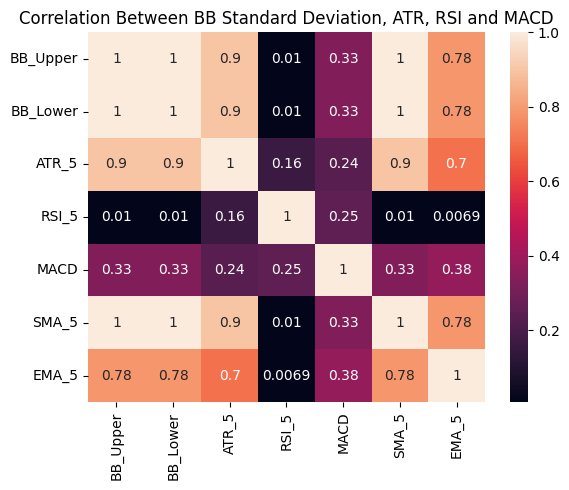

In [134]:
#heat map for just the featured engineered columns
corr = df_cass_final[['BB_Upper', 'BB_Lower', 'ATR_5', 'RSI_5', 'MACD', 'SMA_5','EMA_5']].corr()
sns.heatmap(corr, annot=True)
plt.title("Correlation Between BB Standard Deviation, ATR, RSI and MACD")
plt.show()


### Above is a correlation heat map which helps us see how some of our feature engineered columns correlate with one another. We can see that due to our limited sample size of 3 minutes, our Bollinger Bonds are pretty static and the upper and lower are correlated strongly with SMA_5. This is because we are driving the Bollinger Bonds from SMA_5. Furthermore, EMA is highly correlated with SMA(which is the source of BB_upper and BB_lower). THe remaining columns are not highly correlated with now another. MACD has a moderate correlation with ATR_5 and SMA_5 and the BBs which can show us that the MACD is only tracking pricetrends somewhat effectively not perfectly. RSI_5 seems to have a low to no correlations with anything. 

## Real Time Data Encoding

### The goal is to apply one hot encoding on the tickers so the machine learning model has no issues with the string values. Additionally we are going to convert the datetime into date only, and then split it into year, month, day of month, weekday, hour and minute as well as time of day combining hour and minute (using 24HR clock so HourHourMinuteMinute)

In [135]:

def encodingdatefeatures(df):

    # making sure we turn datae into date time then we can split it
    df['date'] = pd.to_datetime(df['date'])

    # extracting the dates similar to labs
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['weekday'] = df['date'].dt.weekday
    df['day'] = df['date'].dt.day
    df['time_of_day'] = df['date'].dt.hour * 60 + df['date'].dt.minute 

    #using one hot encoding on the ticker since its categorical
    ticker_dummies = pd.get_dummies(df['ticker'], prefix='ticker')

    # adding the onehot encoded column to the dataframe and removing original from DF
    df = pd.concat([df.drop(['ticker', 'date'], axis=1), ticker_dummies], axis=1)
    return df
# applying and printing our results.also wanted to print the column list since it gets abbreviated
df_cass_encoded = encodingdatefeatures(df_cass_final)
display(df_cass_encoded)
print("Printing out all the columns so we can see what we split up: \n")
print(list(df_cass_encoded.columns))

,adj_close,close,high,low,open,previous_close,SMA_5,EMA_5,RSI_5,BB_Middle,...,weekday,day,time_of_day,ticker_AAPL,ticker_AMZN,ticker_GOOGL,ticker_META,ticker_MSFT,ticker_NVDA,ticker_TSLA
0,190.5750,190.5750,193.80,189.8112,193.265,196.98,190.5830,190.580926,0.0,190.5830,...,0,21,1126,True,False,False,False,False,False,False
1,190.5750,190.5750,193.80,189.8112,193.265,196.98,190.5790,190.578951,0.0,190.5790,...,0,21,1126,True,False,False,False,False,False,False
2,190.5750,190.5750,193.80,189.8112,193.265,196.98,190.5750,190.577634,0.0,190.5750,...,0,21,1126,True,False,False,False,False,False,False
3,190.5750,190.5750,193.80,189.8112,193.265,196.98,190.5750,190.576756,0.0,190.5750,...,0,21,1127,True,False,False,False,False,False,False
4,190.4600,190.4600,193.80,189.8112,193.265,196.98,190.5520,190.537837,0.0,190.5520,...,0,21,1127,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,223.7292,223.7292,232.21,222.7900,230.260,241.37,223.9032,223.872596,0.0,223.9032,...,0,21,1128,False,False,False,False,False,False,True
118,223.7292,223.7292,232.21,222.7900,230.260,241.37,223.8597,223.824797,0.0,223.8597,...,0,21,1128,False,False,False,False,False,False,True
119,223.7292,223.7292,232.21,222.7900,230.260,241.37,223.8162,223.792931,0.0,223.8162,...,0,21,1128,False,False,False,False,False,False,True
120,223.7292,223.7292,232.21,222.7900,230.260,241.37,223.7727,223.771688,0.0,223.7727,...,0,21,1128,False,False,False,False,False,False,True


Printing out all the columns so we can see what we split up: 

['adj_close', 'close', 'high', 'low', 'open', 'previous_close', 'SMA_5', 'EMA_5', 'RSI_5', 'BB_Middle', 'BB_Std', 'BB_Upper', 'BB_Lower', 'MACD', 'MACD_Signal', 'ATR_5', 'year', 'month', 'weekday', 'day', 'time_of_day', 'ticker_AAPL', 'ticker_AMZN', 'ticker_GOOGL', 'ticker_META', 'ticker_MSFT', 'ticker_NVDA', 'ticker_TSLA']


# Machine Learning 

### Real Time: Using LSTM first and then XGBoost. Then we can apply an ensemble method where we use weighted averaging between both

/Users/haseemarshad/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_32 (LSTM)                  │ (None, 64)             │        23,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,698 (100.38 KB)

 Trainable params: 25,698 (100.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.2383 - val_loss: 0.0993
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0850 - val_loss: 0.1751
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0491 - val_loss: 0.1496
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0378 - val_loss: 0.1043
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0254 - val_loss: 0.1011
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0303 - val_loss: 0.1030
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0215 - val_loss: 0.1043
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0231 - val_loss: 0.1064
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0173 - val_loss: 0.1035
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0158 - val_loss: 0.1096
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0177 - val_loss: 0.1226
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0135 - val_loss: 0.1183
E

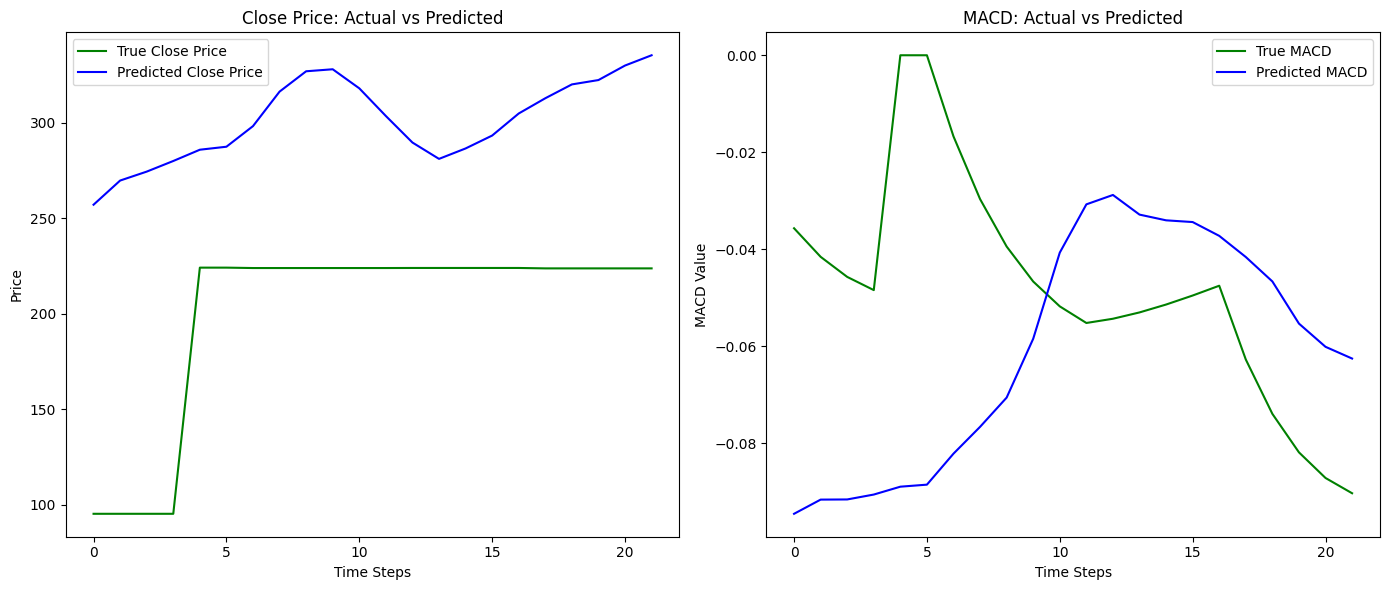

Close Price MSE: 11586.010019438103
Close Price R²: -3.7047302179282813
MACD MSE: 0.0017755804671025937
MACD R²: -2.3343868640502947


In [139]:
df_cass_encoded['target_close'] = df_cass_encoded['close'].shift(-1)
df_cass_encoded['target_macd'] = df_cass_encoded['MACD'].shift(-1)
# identify all of the features and our targets list
features = ['adj_close', 'close', 'high', 'low', 'open', 'previous_close','SMA_5', 'EMA_5', 'RSI_5', 'BB_Middle', 'BB_Std', 'BB_Upper', 'BB_Lower','MACD_Signal', 'ATR_5', 
            'year', 'month', 'weekday', 'day', 'time_of_day','ticker_AAPL', 'ticker_AMZN', 'ticker_GOOGL', 'ticker_META','ticker_MSFT', 'ticker_NVDA', 'ticker_TSLA']
targets = ['target_close', 'target_macd']

#calling the min max standard scaler
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()
scaled_real_features = feature_scaler.fit_transform(df_cass_encoded[features])
scaled_real_targets = target_scaler.fit_transform(df_cass_encoded[targets])

#creating LSTM sequences which are 10 time steps long
def create_sequences(features, targets, sequence_length=10):
    X, y = [], []
    for i in range(len(features) - sequence_length):
        X.append(features[i:i+sequence_length])
        y.append(targets[i+sequence_length])
    return np.array(X), np.array(y)
X, y = create_sequences(scaled_real_features, scaled_real_targets, sequence_length=10)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# creating the LSTM model
model = Sequential([LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),Dense(32, activation='relu'),Dense(y_train.shape[1])])

model.compile(optimizer='adam', loss='mse')
model.summary()

#fitting the model
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_split=0.2)

#model prediction and inverse scaling
y_pred_scaled = model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_orig = target_scaler.inverse_transform(y_test)

# extracting the target variables
pred_close, pred_macd = y_pred[:, 0], y_pred[:, 1]
true_close, true_macd = y_test_orig[:, 0], y_test_orig[:, 1]

#converting to numpy in case theres any nans then filter it out
pred_close = np.array(pred_close)
true_close = np.array(true_close)
pred_macd = np.array(pred_macd)
true_macd = np.array(true_macd)
valid_close = ~np.isnan(pred_close) & ~np.isnan(true_close)
valid_macd = ~np.isnan(pred_macd) & ~np.isnan(true_macd)

#fit the filtering
true_close_clean = true_close[valid_close]
pred_close_clean = pred_close[valid_close]
true_macd_clean = true_macd[valid_macd]
pred_macd_clean = pred_macd[valid_macd]

#settuing up the plot figure
plt.figure(figsize=(14, 6))

# plotting close price for the LSTM model
plt.subplot(1, 2, 1)
plt.plot(true_close_clean, label='True Close Price', color='green')
plt.plot(pred_close_clean, label='Predicted Close Price', color='blue')
plt.title('Close Price: Actual vs Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()

# plotting macd for the LSTM model
plt.subplot(1, 2, 2)
plt.plot(true_macd_clean, label='True MACD', color='green')
plt.plot(pred_macd_clean, label='Predicted MACD', color='blue')
plt.title('MACD: Actual vs Predicted')
plt.xlabel('Time Steps')
plt.ylabel('MACD Value')
plt.legend()
plt.tight_layout()
plt.show()

# printing evaluation statments for MSE and R2 for both close price and macd
print("Close Price MSE:", mean_squared_error(true_close_clean, pred_close_clean))
print("Close Price R²:", r2_score(true_close_clean, pred_close_clean))
print("MACD MSE:", mean_squared_error(true_macd_clean, pred_macd_clean))
print("MACD R²:", r2_score(true_macd_clean, pred_macd_clean))




## importing libomp if you are on macos for the XGBoosting (1/2nd half of real time ensemble model)

In [140]:
!brew install libomp

==> Auto-updating Homebrew...
Adjust how often this is run with HOMEBREW_AUTO_UPDATE_SECS or disable with
HOMEBREW_NO_AUTO_UPDATE. Hide these hints with HOMEBREW_NO_ENV_HINTS (see `man brew`).
==> Auto-updated Homebrew!
Updated 2 taps (homebrew/core and homebrew/cask).
==> New Formulae
brename                    prog8                      technitium-library
cargo-shear                technitium-dns
==> New Casks
highlight                                warp@preview

You have 9 outdated formulae installed.

To reinstall 20.1.3, run:
  brew reinstall libomp


## Creating the code for xgboosting ,  80:20 train:test ratio

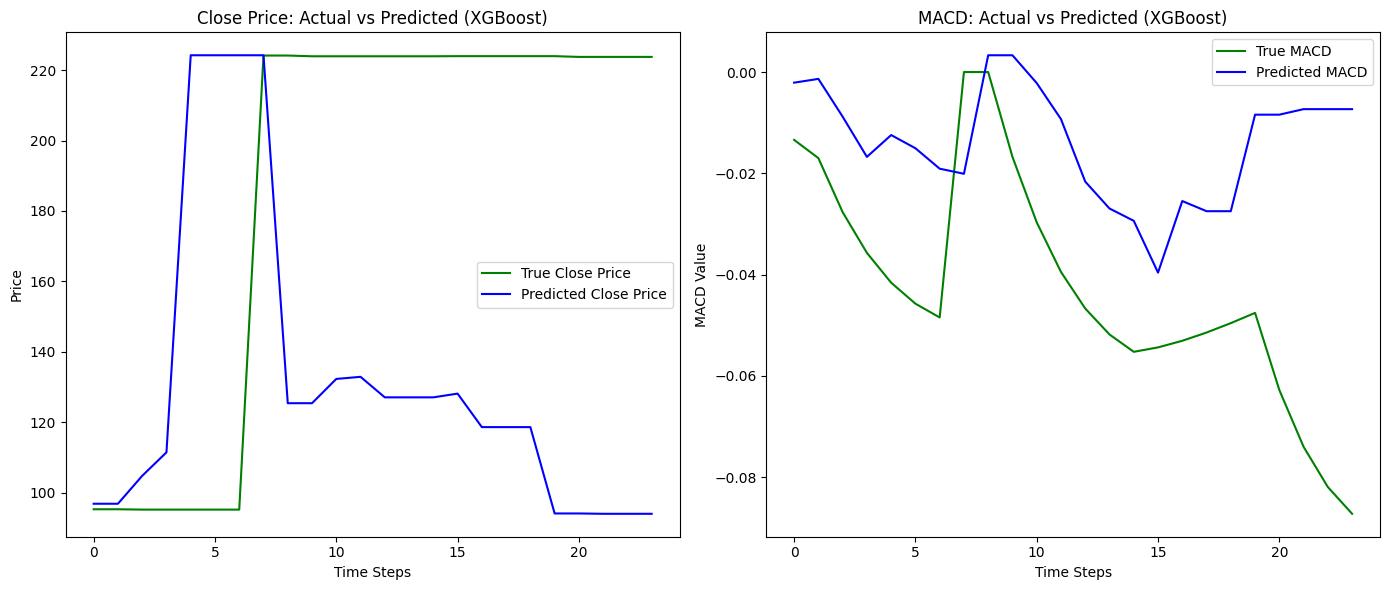

Close Price MSE: 10042.614960029961
Close Price R²: -1.9372447480167416
MACD MSE: 0.0012941878206554154
MACD R²: -1.6132534669303253


In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

# === Step 1: Define targets (next timestep prediction) ===
df_cass_encoded['target_close'] = df_cass_encoded['close'].shift(-1)
df_cass_encoded['target_macd'] = df_cass_encoded['MACD'].shift(-1)
df_cass_encoded.dropna(subset=['target_close', 'target_macd'], inplace=True)

# === Step 2: Feature selection (avoid multicollinearity but preserve signal strength) ===
features = [
    'close', 'high', 'low', 'open', 'previous_close',
    'SMA_5', 'EMA_5', 'RSI_5', 'BB_Upper', 'BB_Lower',
    'MACD_Signal', 'ATR_5', 'time_of_day',
    'ticker_AAPL', 'ticker_AMZN', 'ticker_GOOGL', 
    'ticker_META', 'ticker_MSFT', 'ticker_NVDA', 'ticker_TSLA'
]
targets = ['target_close', 'target_macd']

# === Step 3: Scaling ===
feature_scaler = StandardScaler()
target_scaler = StandardScaler()
X = feature_scaler.fit_transform(df_cass_encoded[features])
y = target_scaler.fit_transform(df_cass_encoded[targets])

# === Step 4: Train-test split (no shuffling for time series) ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# === Step 5: XGBoost Regressor (tuned for low-latency real-time) ===
xgb_model = XGBRegressor(
    n_estimators=80,  # slightly reduced
    max_depth=3,
    learning_rate=0.08,
    subsample=0.9,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)
xgb_model.fit(X_train, y_train)

# === Step 6: Prediction & Evaluation ===
y_pred = xgb_model.predict(X_test)
y_test_orig = target_scaler.inverse_transform(y_test)
y_pred_orig = target_scaler.inverse_transform(y_pred)

true_close, true_macd = y_test_orig[:, 0], y_test_orig[:, 1]
pred_close, pred_macd = y_pred_orig[:, 0], y_pred_orig[:, 1]

# === Step 7: Metrics ===
close_mse = mean_squared_error(true_close, pred_close)
close_r2 = r2_score(true_close, pred_close)
macd_mse = mean_squared_error(true_macd, pred_macd)
macd_r2 = r2_score(true_macd, pred_macd)


# === Step 8: Visualization ===
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(true_close, label='True Close Price', color='green')
plt.plot(pred_close, label='Predicted Close Price', color='blue')
plt.title('Close Price: Actual vs Predicted (XGBoost)')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(true_macd, label='True MACD', color='green')
plt.plot(pred_macd, label='Predicted MACD', color='blue')
plt.title('MACD: Actual vs Predicted (XGBoost)')
plt.xlabel('Time Steps')
plt.ylabel('MACD Value')
plt.legend()

plt.tight_layout()
plt.show()

print("Close Price MSE:", close_mse)
print("Close Price R²:", close_r2)
print("MACD MSE:", macd_mse)
print("MACD R²:", macd_r2)


## Ensembling both models together to get a more consistent result. Applying weighted average ensemble principles since LSTM is better at close prediction but XGBoosting is better at MACD

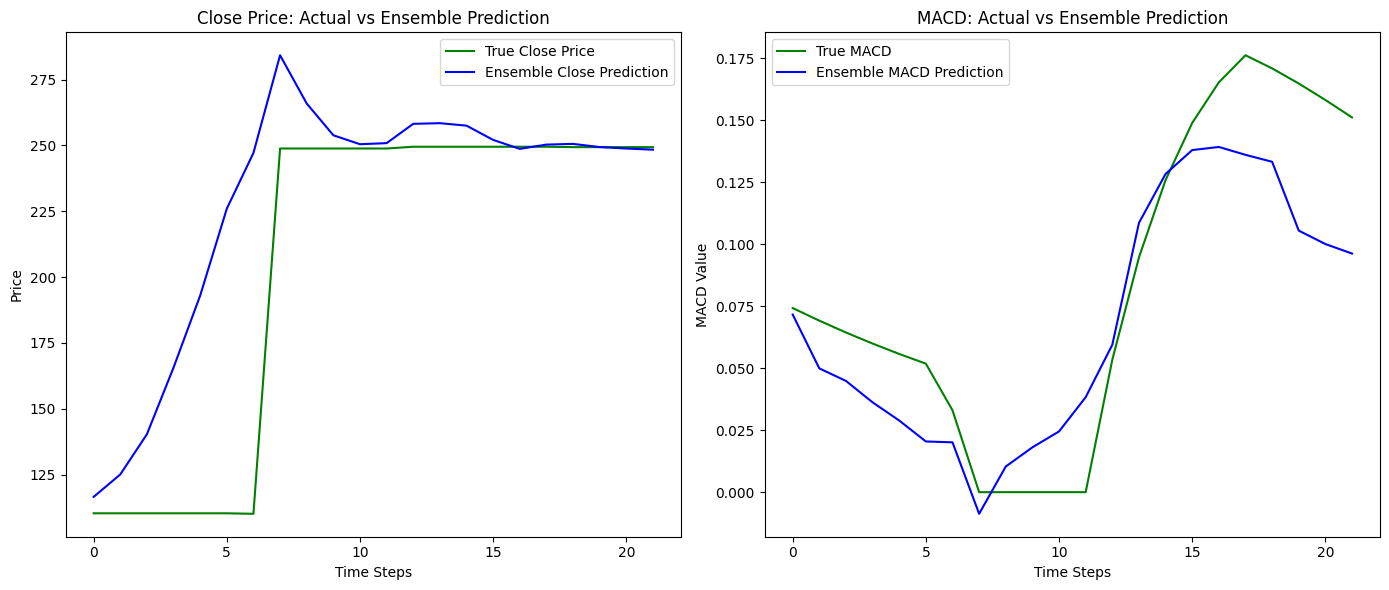

ENSEMBLE Close MSE: 2045.5935754663262
ENSEMBLE Close R²: 0.5115856413382969
ENSEMBLE MACD MSE: 0.0008986001948967047
ENSEMBLE MACD R²: 0.7734746027788532


In [69]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# === Step 1: Align array lengths for ensembling ===
min_len = min(len(pred_close_clean), len(pred_close))

true_close_aligned = true_close[:min_len]
true_macd_aligned = true_macd[:min_len]

pred_close_clean = pred_close_clean[:min_len]  # LSTM
pred_macd_clean = pred_macd_clean[:min_len]

pred_close = pred_close[:min_len]  # XGBoost
pred_macd = pred_macd[:min_len]

# === Step 2: Weighted Average Ensemble ===
# Example weights: LSTM 60%, XGBoost 40% for close price, and flipped for MACD
w_lstm_close = 0.7
w_xgb_close = 0.3

w_lstm_macd = 0.3
w_xgb_macd = 0.7

ensemble_pred_close = (w_lstm_close * pred_close_clean) + (w_xgb_close * pred_close)
ensemble_pred_macd = (w_lstm_macd * pred_macd_clean) + (w_xgb_macd * pred_macd)

# === Step 3: Evaluate Ensemble Performance ===
close_mse = mean_squared_error(true_close_aligned, ensemble_pred_close)
close_r2 = r2_score(true_close_aligned, ensemble_pred_close)

macd_mse = mean_squared_error(true_macd_aligned, ensemble_pred_macd)
macd_r2 = r2_score(true_macd_aligned, ensemble_pred_macd)

# === Step 4: Plotting ===
plt.figure(figsize=(14, 6))

# Plot Close Price
plt.subplot(1, 2, 1)
plt.plot(true_close_aligned, label='True Close Price', color='green')
plt.plot(ensemble_pred_close, label='Ensemble Close Prediction', color='blue')
plt.title('Close Price: Actual vs Ensemble Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()

# Plot MACD
plt.subplot(1, 2, 2)
plt.plot(true_macd_aligned, label='True MACD', color='green')
plt.plot(ensemble_pred_macd, label='Ensemble MACD Prediction', color='blue')
plt.title('MACD: Actual vs Ensemble Prediction')
plt.xlabel('Time Steps')
plt.ylabel('MACD Value')
plt.legend()

plt.tight_layout()
plt.show()

print("ENSEMBLE Close MSE:", close_mse)
print("ENSEMBLE Close R²:", close_r2)
print("ENSEMBLE MACD MSE:", macd_mse)
print("ENSEMBLE MACD R²:", macd_r2)


versus running LSTM 5 times averaging it. then running xgboosting 5 times, averaging it. then ensembling both together with weighted. It would be beneficial beacuase if we run:

Running 5x LSTM we are averaging over the 5 results. → reduces the noise/variance in deep model outputs

Running 5x XGBoost averaging over the 5 results again. → stabilizes over tree splits and random seeds

Afterwards we combine the best of both worlds. Weighted ensemble → combines sequential insight (LSTM) and pattern recognition (XGB)